In [39]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import pandas as pd
from spock import StabilityClassifier

In [2]:
def set_timestep(sim,dtFactor):
        ps=sim.particles[1:]
        Tperi=np.min([p.P * (1-p.e)**1.5 / np.sqrt(1+p.e) for p in ps])
        dt = Tperi * dtFactor
        sim.dt = dt
def set_min_distance(sim,rHillFactor):
        ps=sim.particles[1:]
        rHill = np.min([p.rhill for p in ps if p.m > 0])
        minDist = rHillFactor * rHill
        sim.exit_min_distance=minDist

In [16]:
KepID = 138
try:
    df = pd.read_csv("Kepler-{0}_default_priors.csv".format(KepID), index_col=0)
except:
    post_file = "NBody_MCMC_Posteriors.hdf5"
    post_data = h5py.File(post_file,"r")
    data = post_data['Kepler-{0}/DefaultPriors/PosteriorSample'.format(KepID)]
    npl = data.shape[1]//5
    col_heads = []
    for i in range(npl):
        col_heads += ['mu{}'.format(i),'per{}'.format(i),'h{}'.format(i),'k{}'.format(i),'Tc{}'.format(i)]
    df = pd.DataFrame(data=data,columns=col_heads)
    print(df.shape)
    
    for i in range(npl):
        h = df['h{}'.format(i)]
        k = df['k{}'.format(i)]
        per = df['per{}'.format(i)]
        Tc = df['Tc{}'.format(i)]
        df['pomega{}'.format(i)] = np.arctan2(k,h)
        df['e{}'.format(i)] = np.sqrt(h**2 + k**2)
        df['mean_long{}'.format(i)] = np.mod(-2 * np.pi * Tc / per,2*np.pi)
        
    df.to_csv("Kepler-{0}_default_priors.csv".format(KepID))

(250400, 15)


In [17]:
df.tail()

,mu0,per0,h0,k0,Tc0,mu1,per1,h1,k1,Tc1,...,Tc2,pomega0,e0,mean_long0,pomega1,e1,mean_long1,pomega2,e2,mean_long2
250395,6.276470e-08,10.312646,-0.005490,-0.011076,56.221581,0.000002,13.781053,-0.007618,-0.023574,55.695029,...,58.590159,-2.030991,0.012362,3.444992,-1.883350,0.024774,6.022933,0.297010,0.112843,2.906172
250396,5.520660e-08,10.312646,0.021851,0.187269,56.306723,0.000002,13.781033,0.015970,0.148730,55.793374,...,58.629197,1.454639,0.188539,3.393116,1.463830,0.149584,5.978058,0.902959,0.200071,2.895494
250397,1.177300e-07,10.312784,-0.228474,0.256511,55.617878,0.000002,13.781078,-0.199026,0.207599,54.979889,...,57.504890,2.298450,0.343509,3.813263,2.335114,0.287592,0.065846,1.797352,0.222344,3.201414
250398,4.632724e-08,10.312804,0.010612,0.011735,56.273300,0.000003,13.781016,0.006179,0.000144,55.758010,...,58.504957,0.835596,0.015821,3.414005,0.023287,0.006181,5.994149,0.479481,0.109632,2.929361
250399,5.976524e-07,10.313214,-0.000613,-0.016810,56.232538,0.000011,13.781160,0.001245,-0.017727,55.733988,...,58.117184,-1.607256,0.016822,3.440202,-1.500679,0.017771,6.005368,0.528138,0.048321,3.035790


In [249]:
def dfrow_to_sim(row,npl):
    sim = rebound.Simulation()
    sim.units = ('Msun','days','AU')
    sim.add(m=1)
    for i in range(npl):
        mu = row['mu{}'.format(i)]
        per = row['per{}'.format(i)]
        e = row['e{}'.format(i)]
        mean_long = row['mean_long{}'.format(i)]
        pomega = row['pomega{}'.format(i)]
        sim.add(m=mu,P=per,e=e,l=mean_long,pomega=pomega,hash=i)
    sim.move_to_com()
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode =0
    set_timestep(sim,1/30)
    set_min_distance(sim,3)
    return sim

In [251]:
sim = dfrow_to_sim(df.iloc[1],npl)

In [252]:
sim.N

4

In [253]:
ps = sim.particles
print(ps[2].P/ps[1].P)
print(ps[3].P/ps[2].P)

1.3363019070501019
1.6755063328665785


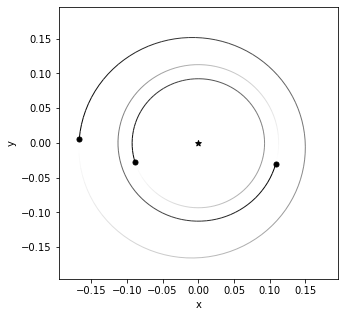

In [254]:
fig = rebound.OrbitPlot(sim)

In [255]:
model = StabilityClassifier()

In [256]:
model.predict(sim)

0.8145148754119873

j:j-k

In [259]:
from celmech import Andoyer

avars = Andoyer.from_Simulation(sim, j=4, k=1, i1=1, i2=2)
avars.Z

0.06550839859746588

In [260]:
avars = Andoyer.from_Simulation(sim, j=5, k=2, i1=2, i2=3)
avars.Z

0.16021300528254453

In [257]:
def varyZ(sim0, Z12, Z23):
    ps0 = sim0.particles
    sim = rebound.Simulation()
    sim.units = ('Msun','days','AU')
    sim.add(m=1)
    sim.add(m=ps0[1].m, a=ps0[1].a, l=ps0[1].l, e=Z12, pomega=0)
    sim.add(m=ps0[2].m, a=ps0[2].a, l=ps0[2].l, e=0, pomega=0)
    sim.add(m=ps0[3].m, a=ps0[3].a, l=ps0[3].l, e=Z23, pomega=0)
    sim.move_to_com()
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode =0
    set_timestep(sim,1/30)
    set_min_distance(sim,3)
    return sim

In [258]:
sim = dfrow_to_sim(df.iloc[1],npl)
sim = varyZ(sim, 0.1, 0.2)
model.predict(sim)

0.33527934551239014

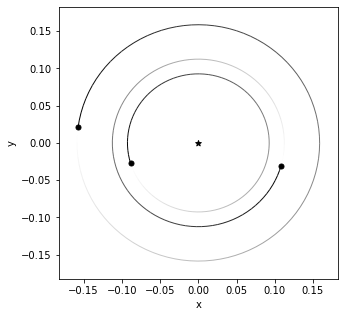

In [162]:
fig = rebound.OrbitPlot(sim)

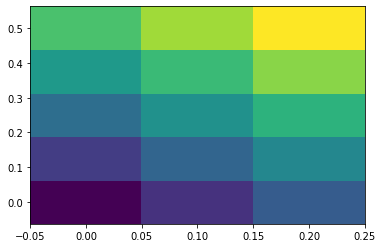

In [237]:
e1 = np.linspace(0, 0.2, 3)
e3 = np.linspace(0, 0.5, 5)

de1 = e1[1]-e1[0]
de3 = e3[1]-e3[0]

# pcolormesh takes the boundaries of each cell in X and Y, so need to offset by half dX, and add one at end at X[-1]+dX/2
e1g = [e - de1/2 for e in e1] + [e1[-1]+de1/2]
e3g = [e - de3/2 for e in e3] + [e3[-1]+de3/2]

X, Y = np.meshgrid(e1g, e3g)

Z = np.zeros((len(e3), len(e1))) # shape = (rows, col) so (Y,X)
for i, e1v in enumerate(e1):
    for j, e3v in enumerate(e3):
        Z[j,i] = e1v + e3v

z_min, z_max = -abs(Z).max(), abs(Z).max()

fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, Z)

In [246]:
%%time

Ne1 = 30
Ne3 = 30
e1max = 0.5
e3max = 0.5

e1 = np.linspace(0, e1max, Ne1)
e3 = np.linspace(0, e3max, Ne3)

de1 = e1[1]-e1[0]
de3 = e3[1]-e3[0]

# pcolormesh takes the boundaries of each cell in X and Y, so need to offset by half dX, and add one at end at X[-1]+dX/2
e1g = [e - de1/2 for e in e1] + [e1[-1]+de1/2]
e3g = [e - de3/2 for e in e3] + [e3[-1]+de3/2]

X, Y = np.meshgrid(e1g, e3g)

Z = np.zeros((Ne3, Ne1)) # shape = (rows, col) so (Y,X)
for i, e1v in enumerate(e1):
    for j, e3v in enumerate(e3):
        sim = dfrow_to_sim(df.iloc[0],npl)
        sim = varyZ(sim, e1v, e3v)
        Z[j,i] = model.predict(sim)

z_min, z_max = -abs(Z).max(), abs(Z).max()

CPU times: user 1h 11min 19s, sys: 1min 36s, total: 1h 12min 56s
Wall time: 15min 56s


Text(0, 0.5, 'e3')

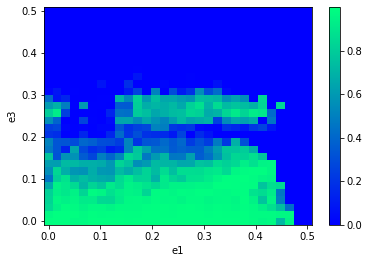

In [247]:
fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, Z, cmap='winter')
fig.colorbar(im)
ax.set_xlabel('e1')
ax.set_ylabel('e3')